<a href="https://colab.research.google.com/github/heesukjang/W207_AppliedML_Fall2022/blob/main/05_Multiclass_Classification_heesuk_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5

Student: **Heesuk Jang**<br>
Class: **W207 Section 8**<br>
Instructor: **Cornelia Ilin**

This lab extends binary logistic regression to [multi-class logistic regression](https://en.wikipedia.org/wiki/Multinomial_logistic_regression), which goes by a variety of names, including *softmax regression*, due to the use of the softmax function, which generalizes the logistic function.

In [1]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

We again load the Fashion MNIST dataset, though this time around, we'll use all 10 output classes.

In [2]:
from keras.datasets import fashion_mnist

# Load the Fashion MNIST dataset.
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
X_train = X_train / 255
X_test = X_test / 255

# Flatten Y_train and Y_test, so they become vectors of label values.
# The label for X_train[0] is in Y_train[0].
Y_train = Y_train.flatten()
Y_test = Y_test.flatten()

label_names = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
               'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train = X_train[shuffled_indices]
Y_train = Y_train[shuffled_indices]

4431872/4422102 [==============================] - 0s 0us/step


### Cross-Entropy Loss

Recall the log loss function (also called binary cross-entropy):

\begin{equation}
-y log(\hat{y}) + (1−y)log(1−\hat{y})
\end{equation}

In the above formulation, it is assumed that $y$ is either 0 or 1, so either the left term or the right term is active for each example.

The general form for cross-entropy is used when $y$ is assumed to be a label vector with a 1 in the index of the true label and a 0 everywhere else: $y=[0,0,0,0,0,0,0,1,0,0]$ implies a label of "sneaker" in this dataset (the 7th label). Accordingly, $\hat{y}$ is a vector of predicted probabilities. Then the cross-entropy loss is simply:

\begin{equation}
-\sum_{j} y_j log(\hat{y}_j)
\end{equation}

As in the binary case, this summation will have exactly 1 non-zero term where the true label $y_j=1$.

Note that this formulation is using a **dense representation** of the label. The corresponding **sparse representation** would use the non-zero index directly ($y=7$).

## Build a model

Let's construct a model much like we did in the binary classification case, but now with a multi-class output.

---
### Exercise 1 (8 points)

Fill in the NotImplemented parts of the build_model function below. You will need to make the following changes to generalize the binary case to the multi-class case:
* The output will include 10 probabilities instead of 1.
* Use a softmax function instead of a sigmoid.
* Use a [sparse_categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy) loss instead of binary_crossentropy. Note that "sparse" refers to the use of a sparse index (e.g. 7) to indicate the label rather than a dense vector (e.g. [0,0,0,0,0,0,0,1,0,0]).

Check that training works below.

In [3]:
def build_model(n_classes, learning_rate=0.01):
  """Build a multi-class logistic regression model using Keras.

  Args:
    n_classes: Number of classes in the dataset
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  model = keras.Sequential()
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(
      # YOUR CODE HERE
      units=10,                          # output dim
      activation='softmax'
  ))

  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    
  # YOUR CODE HERE
  model.compile(loss='sparse_categorical_crossentropy',  
                optimizer=optimizer, 
                metrics=['accuracy'])
  return model

Make sure your model trains. If you configured it properly, the training loss should get to ~0.55 after 5 epochs.

In [4]:
model = build_model(len(label_names), 0.01)

history = model.fit(
  x = X_train,
  y = Y_train,
  epochs=5,
  batch_size=64,
  validation_split=0.1,
  verbose=1)

history = pd.DataFrame(history.history)
display(history)

Epoch 1/5
844/844 [==============================] - 4s 4ms/step - loss: 0.9976 - accuracy: 0.6943 - val_loss: 0.7644 - val_accuracy: 0.7502
Epoch 2/5
844/844 [==============================] - 3s 4ms/step - loss: 0.6845 - accuracy: 0.7816 - val_loss: 0.6679 - val_accuracy: 0.7762
Epoch 3/5
844/844 [==============================] - 3s 4ms/step - loss: 0.6161 - accuracy: 0.8030 - val_loss: 0.6231 - val_accuracy: 0.7885
Epoch 4/5
844/844 [==============================] - 3s 3ms/step - loss: 0.5787 - accuracy: 0.8139 - val_loss: 0.5986 - val_accuracy: 0.7980
Epoch 5/5
844/844 [==============================] - 4s 4ms/step - loss: 0.5544 - accuracy: 0.8201 - val_loss: 0.5761 - val_accuracy: 0.8060


,loss,accuracy,val_loss,val_accuracy
0,0.997606,0.694278,0.764360,0.750167
1,0.684474,0.781648,0.667892,0.776167
2,0.616129,0.802981,0.623094,0.788500
3,0.578731,0.813926,0.598561,0.798000
4,0.554377,0.820130,0.576119,0.806000


### Evaluation Metrics

Classification metrics like accuracy, precision, and recall can all be derived from a confusion matrix which displays the counts for all pairs of true label and predicted label. Correct predictions are on the diagonal and incorrect predictions (confusions) are off the diagonal.

First, we need the predicted labels from the model.

### [HEESUK'S NOTE:](https://www.sharpsightlabs.com/blog/numpy-argmax/)
- **np.argmax()** finds the maximum value along the axis and returns the index of that value.
The following is the example of axis = 1:
![Screen Shot 2022-09-20 at 1.52.47 PM.png](attachment:a1126634-babd-44f3-91a6-64f6c5418b52.png)

In [5]:
# Recall that model.predict gives a vector of probabilities for each x.
# Get labels by taking the argmax -- the index with the largest probability.
test_predictions = np.argmax(model.predict(X_test), axis=-1)      # axis=-1: the last axis
print(f'len(test_predictions): {len(test_predictions)}\ntest_predictions: {test_predictions})')

len(test_predictions): 10000
test_predictions: [9 2 1 ... 8 1 5])


Next, we create a confusion matrix and produce an easy-to-read visualization.

In [6]:
print(f'len(Y_test) = {len(Y_test)} | Y_test = {Y_test} | np.unique() = {np.unique(Y_test)}')
print(f'len(test_pred) = {len(test_predictions)} | test_pred = {test_predictions} | np.unique() = {np.unique(test_predictions)}')

len(Y_test) = 10000 | Y_test = [9 2 1 ... 8 1 5] | np.unique() = [0 1 2 3 4 5 6 7 8 9]
len(test_pred) = 10000 | test_pred = [9 2 1 ... 8 1 5] | np.unique() = [0 1 2 3 4 5 6 7 8 9]


[tf.math.confusion_matrix ](https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix)<br>
The matrix columns represent the prediction labels and the rows represent the real labels. The confusion matrix is always a 2-D array of shape [n, n], where n is the number of valid labels for a given classification task. Both prediction and labels must be 1-D arrays of the same shape in order for this function to work.

tf.Tensor(
[[787   6  12  59   6   1 108   0  20   1]
 [  6 930  16  39   6   0   1   0   2   0]
 [ 15   0 669   8 188   1 101   0  18   0]
 [ 32  18   7 849  42   1  47   0   4   0]
 [  0   3  93  39 771   0  88   0   6   0]
 [  1   0   0   2   0 811   0 103  10  73]
 [148   3 133  36 131   1 514   0  34   0]
 [  0   0   0   0   0  36   0 898   0  66]
 [  2   1  12  11   3   6  24   9 931   1]
 [  0   0   0   0   0  12   1  54   1 932]], shape=(10, 10), dtype=int32) 



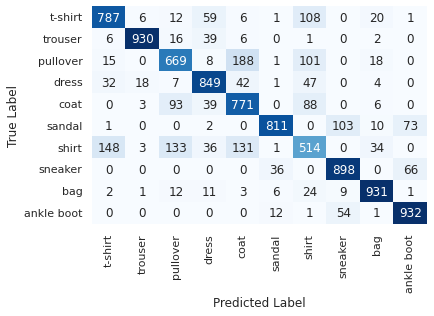

Sum of each row is 1000


In [7]:
# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(Y_test, test_predictions)   # Y_test
print(confusion_matrix, '\n')
# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=label_names, yticklabels=label_names, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()
print('Sum of each row is 1000')

In [8]:
label_names = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
               'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

list(zip:
 [(0.7941473259334006, 't-shirt'), (0.967741935483871, 'trouser'), (0.7101910828025477, 'pullover'), (0.8139980824544583, 'dress'), (0.6721883173496077, 'coat'), (0.9332566168009206, 'sandal'), (0.581447963800905, 'shirt'), (0.8439849624060151, 'sneaker'), (0.9074074074074074, 'bag'), (0.8685927306616962, 'ankle boot')] 

t-shirt class has precision : 0.7941473259334006
trouser class has precision : 0.967741935483871
pullover class has precision : 0.7101910828025477
dress class has precision : 0.8139980824544583
coat class has precision : 0.6721883173496077
sandal class has precision : 0.9332566168009206
shirt class has precision : 0.581447963800905
sneaker class has precision : 0.8439849624060151
bag class has precision : 0.9074074074074074
ankle boot class has precision : 0.8685927306616962


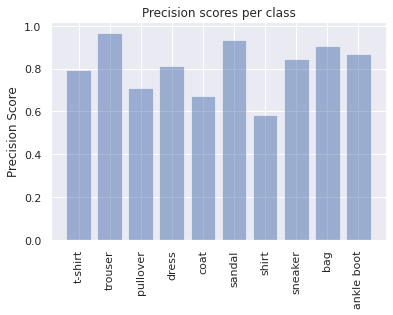

In [9]:
# # Srila's code
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

# Calculate precision scores
image_classification_precision_scores = precision_score(Y_test, test_predictions, average = None)

print('list(zip:\n',list(zip(image_classification_precision_scores, label_names)),'\n')
y_pos = np.arange(len(image_classification_precision_scores))
plt.bar(y_pos, image_classification_precision_scores, align = 'center', alpha = 0.5)
plt.xticks(y_pos, label_names, rotation = 90)
plt.ylabel('Precision Score')
plt.title('Precision scores per class')
for prec, lbl in list(zip(image_classification_precision_scores, label_names)):
    print(f"{lbl} class has precision : {prec}")
plt.show()

In [10]:
conf_matrix_array = confusion_matrix.numpy()    # convert tf.Tensor to 2d array
for diag in range(conf_matrix_array.shape[0]):
    tp = conf_matrix_array[diag, diag]           # diagnol values
    fp = sum(other for other in conf_matrix_array[:,diag] if other != tp)   # conf_matrix_array[:,diag] = a column vector (= prediction label)
    fn = sum(other for other in conf_matrix_array[diag,:] if other != tp)   # conf_matrix_array[diag,:] = a row vector (= true label)
    
    precision = tp / (tp + fp) * 100
    recall = tp / (tp + fn) * 100
    print(f'Class {diag}:   Precision = {round(precision, 2)}%  |  Recall = {round(recall, 2)}% ==> {label_names[diag]}')

AttributeError: ignored

In [ ]:
# conf_matrix_array = confusion_matrix.numpy()
# print(conf_matrix_array)
# print(conf_matrix_array.shape)
# print(conf_matrix_array[1,1])   # diagnol values
# print(conf_matrix_array[:,1])   # values of a single column
# print(conf_matrix_array[1,:])   # values of a single row

Sneaker (positive class) vs. Non-sneaker (negative class)<br>
**TP**: actual lable = sneaker, predicted = sneaker ==> correct<br>
**TN**: actual lable = non-sneaker, predicted = non-sneaker ==> correct<br>
**FP**: actual lable = non-sneaker, predicted = sneaker ==> incorrect<br>
**FN**: actual lable = sneaker, predicted = non-sneaker ==> incorrect<br>

**Accuracy** = (TP + TN) / (TP + TN + FP +FN)<br>
**Precision** = TP / (TP + FP)<br>
**Recall** = TP / (TP + FN)<br>


---
### Exercise 2 (8 points)

Answer the following questions by studying the confusion matrix (above).

1. Which class has the lowest precision? What is that precision? Which class has the highest precision? What is that precision?
2. For the class 'sneaker', what class is the largest source of false negatives? What about the largest source of false positives?

*Written answer:*

1. **Class 6 (shirt):** the lowest precision with 57.92% and **Class 1 (trouser):** the highest precision with 96.58% 
2. For the class 'sneaker', the **ankle boot** is the largest source of false negatives while **sandal** is the largest source of false positives.

---

## Analyze Errors

A crucial part of the development cycle in Machine Learning is analyzing errors to help understand the shortcomings of the model. While typically we'd want to use the development data for this purpose to preserve the purity of the test set, we'll just use our test split for simplicity.

Since the "shirt" class seems to be the source for a lot of errors, let's look at some of the confusions.

![Screen Shot 2022-09-21 at 8.54.55 AM.png](attachment:c81f7875-a081-4e64-a913-b78adfd2a91e.png)

---
### Exercise 3 (8 points)

1. Display 5 images with true label "shirt", but predicted label "coat" (false negatives for the "shirt" class).
2. Display 5 images with predicted label "shirt", but true label "coat" (false positives for the "shirt" class).

In [ ]:
# YOUR CODE HERE

# Answers to both Q1 and Q2:
def fn_fp_for_shirt(true_test, pred_test, true_label, pred_label, label_names):
    idx_true_label = label_names.index(true_label)
    idx_pred_label = label_names.index(pred_label)
    
    indexes_true_label = [idx for idx, val in enumerate(Y_test) if val == idx_true_label]
    indexes_pred_label = [idx for idx, val in enumerate(test_predictions) if val == idx_pred_label]
    matching_idx =  [i for i in indexes_true_label if i in indexes_pred_label][:5]
#     print('matching_idx = ', matching_idx)
    
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15,6))
    for idx, img_idx in enumerate(matching_idx):
        image = X_test[img_idx]
        axs[idx].imshow(image)    
        axs[idx].set_title(f'True:{label_names[idx_true_label]} | Pred:{label_names[idx_pred_label]}')
        axs[idx].axis('off')
    plt.show()

fn_fp_for_shirt(Y_test, test_predictions, 'shirt', 'coat', label_names)
fn_fp_for_shirt(Y_test, test_predictions, 'coat', 'shirt', label_names)

In [ ]:
# Srila's code

# false_positive_classified_shirts = []
# false_negative_classified_shirts = []
# for idx, val in enumerate(zip(Y_test, test_predictions)):
#     actual, predict = val[0], val[1]
#     if (actual != predict and actual == 6 and predict == 4) or (actual != predict and actual == 4 and predict == 6):
#         if (actual != predict and actual == 6 and predict == 4):
#             false_negative_classified_shirts.append((actual, predict, idx, 1))
#         elif (actual != predict and actual == 4 and predict == 6):
#             false_positive_classified_shirts.append((actual, predict, idx, 2))

# print(false_negative_classified_shirts[:5])
# print(false_positive_classified_shirts[:5])

# plt.figure(figsize=(15,15))
# for index, fn_image in enumerate(false_negative_classified_shirts[:5]):
# #     print(index, fn_image)
#     plt.xticks([])
#     plt.yticks([])
#     plt.subplot(4, 5, index + 1)
#     plt.imshow(np.reshape(X_test[fn_image[2]], (28,28)))
#     plt.title('Actual: {}, Pred: {}'.format(label_names[6], label_names[4]), fontsize = 10)

# plt.figure(figsize=(15,15))
# for index, fp_image in enumerate(false_positive_classified_shirts[:5]):
#     print(index, fp_image)
#     plt.xticks([])
#     plt.yticks([])
#     plt.subplot(4, 5, index + 1)
#     plt.imshow(np.reshape(X_test[fp_image[2]], (28,28)))
#     plt.title('Actual: {}, Pred: {}'.format(label_names[4], label_names[6]), fontsize = 10)

In [ ]:
# fn_for_shirt = conf_matrix_array[6,4]
# fp_for_shirt = conf_matrix_array[4,6]
# print('FN for shirt = ', fn_for_shirt, ' | ', 'FP for shirt = ', fp_for_shirt)

# 1. find 5 shirts that are mislabeled as coats in prediction
# 2. find 5 coats that are mislabeled as shirts in prediction
# print(Y_test[10:20])
# print(test_predictions[10:20])
# print(list(zip(Y_test, test_predictions))[10:20])
# print(f'len(Y_test) = {len(Y_test)} | Y_test = {Y_test} | np.unique() = {np.unique(Y_test)}')
# print(f'len(test_pred) = {len(test_predictions)} | test_pred = {test_predictions} | np.unique() = {np.unique(test_predictions)}')
# print()


# print('\nshirt_idx:\n',shirt_idx)
# print('coat_idx:\n',coat_idx)
# print('\nset(shirt_idx)&set(coat_idx):\n', set(a) & set(b))
# print('\nset(shirt_idx)&set(coat_idx):\n', [i for i, j in zip(shirt_idx,coat_idx) if j==j])

print(Y_test[10:20])
print(test_predictions[10:20])
print(Y_test[17])
print(test_predictions[17])

---

## Visualize Parameters
Finally, here's some code that helps visualize the learned parameters for each class.

In [ ]:
weights, biases = model.layers[1].get_weights()
fig, axs = plt.subplots(2, 5, figsize=(16,7))
# print('axs.flatten(): ', axs.flatten())
for i, ax in enumerate(axs.flatten()):
#     print(weights[:,i].reshape(28,28))
    ax.imshow(weights[:,i].reshape(28,28), cmap='PRGn')
    ax.axis('off')
    ax.set_title(label_names[i])
plt.show()